### Verificando o efeito do desdobramento de features. Nesse notebook o desdobramento de features SIM é feito.

A comparação pode ser feita com o notebook exploring 3

In [1]:
import preprocessing.read as r
import preprocessing.st_ops as ops
import preprocessing.feature_ops as feat
import visualization.builders as vis

import torch

from torch_geometric.data import Data
from torch_geometric.data import Batch

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

import numpy as np
from scipy.spatial.transform import Rotation as R

from pythreejs import *

from math import pi

# Lendo dataset

In [2]:
loader = r.TaekwondoLoader('../dataset')
athletes, labels, label_idx = loader.load();
print(labels)
print(athletes[0])
print(label_idx)

l = { idx: key for (idx, key) in enumerate(labels)}

{'Left Kick To The Head', 'Right Kick To The Head', 'Right Kick', 'Back Kick', 'Right Punch', 'Left Punch', 'Left Kick'}
Athlete  8
	Left Punch -> 18 frames
	Right Kick To The Head -> 27 frames
	Right Punch -> 24 frames
	Left Kick -> 26 frames
	Right Kick -> 39 frames
	Back Kick -> 44 frames
	Left Kick To The Head -> 41 frames

{'Left Kick To The Head': 0, 'Right Kick To The Head': 1, 'Right Kick': 2, 'Back Kick': 3, 'Right Punch': 4, 'Left Punch': 5, 'Left Kick': 6}


In [3]:
frame = athletes[0].get('Back Kick')[0]
print(frame)

[[  31.396835  379.187256 2674.777832]
 [-120.293671  370.172241 2366.48291 ]
 [-127.841354  572.247986 2565.340088]
 [  37.214878  167.52269  2486.507324]
 [  73.489693  -42.331818 2360.136963]
 [ 164.266663  -36.93692  2544.631592]
 [   0.          0.          0.      ]
 [  31.374451   84.170746 2674.909424]
 [ -71.856354   75.832153 2220.5625  ]
 [  27.544174 -209.728271 2649.543213]
 [-204.983688 -189.619232 2283.550049]
 [  44.721283 -440.499054 2584.800537]
 [ 135.381165 -489.137695 2363.15332 ]
 [ 274.684814 -755.539368 2478.226318]
 [ 193.036957 -912.540833 2427.563965]
 [ -44.448421  374.679749 2520.630371]]


# Normalizando as features

Aqui estou normalizando as features espaciais. O observador atento perceberá que uso o mesmo fator de escala para todas as dimensões e centralizando as coordenadas em torno da origem. Por preservar as proporções, isso me permitirá gerar pequenas rotações no atleta com maior facilidade.

Também estou escalando por atleta, numa tentativa de normalizar os dados em relação a altura dos atletas. Isso posteriormente pode ser revertido ao fazer data augmentation.

In [4]:
for athlete in athletes:

    min_y = float("inf")
    max_y = -float("inf")
    min_x = float("inf")
    max_x = -float("inf")
    min_z = float("inf")
    max_z = -float("inf")

    for label in labels:
        activity = athlete.get(label)
        min_x = min(min_x, activity[:,:,0].min())
        max_x = max(max_x, activity[:,:,0].max())
        min_y = min(min_y, activity[:,:,1].min())
        max_y = max(max_y, activity[:,:,1].max())
        min_z = min(min_z, activity[:,:,2].min())
        max_z = max(max_z, activity[:,:,2].max())

    scale = (max_y - min_y)/2  # A mesma escala será usada nas 3 dimensões para preservar proporção
    move_x = -(min_x + max_x)/2
    move_y = -(min_y + max_y)/2
    move_z = -(min_z + max_z)/2

    for label in labels:
        activity = athlete.get(label)
        activity[:,:,0] = (activity[:,:,0] + move_x)/scale
        activity[:,:,1] = (activity[:,:,1] + move_y)/scale
        activity[:,:,2] = (activity[:,:,2] + move_z)/scale

In [5]:
dataset = athletes
cut_point = int(len(dataset)*0.8)
permutation = np.random.permutation(len(dataset))
train_set_idx = permutation[:cut_point]
validation_set_idx = permutation[cut_point:]
print(train_set_idx)
print(validation_set_idx)

[0 2 3 4 7 8 1 5]
[6 9]


In [6]:
num_athletes = len(athletes)
num_new_athletes = 62
train_athletes = [athletes[i] for i in train_set_idx ]
validation_athletes = [athletes[i] for i in validation_set_idx ]
for i in range(num_new_athletes):
    angle = np.random.randint(50) - 25
    base_idx = np.random.randint(len(train_set_idx))
    base_athlete = athletes[train_set_idx[base_idx]]
    new_athlete = r.TaekwondoAthlete(i+num_athletes)   
    for label in labels:
        temp = base_athlete.get(label)
        temp = feat.rotate(temp, angle)
        temp = feat.apply_noise(temp, 0.1)
        new_athlete.add(label, temp)
        
    train_athletes.append(new_athlete)
    
print('Dataset de treinamento: {} instâncias'.format(len(train_athletes)))

Dataset de treinamento: 70 instâncias


# Matriz de adjacências do esqueleto

![title](skeleton_model.png)

In [7]:
adj_list = {
    0: [3, 7, 15, 6],
    1: [3, 8, 15, 6],
    2: [15, 6],
    3: [0, 1, 4, 5, 15, 6],
    4: [3, 5, 12, 6],
    5: [3, 4, 11, 6],
    6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    7: [0, 9, 6],
    8: [1, 10, 6],
    9: [7, 6],
    10: [8, 6],
    11: [5, 13, 6],
    12: [4, 14, 6],
    13: [11, 6],
    14: [12, 6],
    15: [0, 1, 2, 3, 6]
}

In [8]:
if False:
    adj_list = {
        0: [3, 7, 19],
        1: [3, 8, 19],
        2: [19],
        3: [0, 1, 4, 5, 19],
        4: [3, 5, 14],
        5: [3, 4, 13],
        7: [0, 9],
        8: [1, 10],
        9: [7],
        10: [8],
        13: [5, 15],
        14: [4, 16],
        15: [13],
        16: [14],
        19: [0, 1, 2, 3]
    }

In [37]:
node_html_colors = { 
    0: '#FFFF00',
    1: '#02FF00',
    2: '#666666',
    3: '#FF00FF',
    4: '#02FF00',
    5: '#FFFF00',
    6: '#666666',
    7: '#FF9802',
    8: '#02FFFF',
    9: '#FF0000',
    10: '#0600FF',
    11: '#FF9802',
    12: '#02FFFF',
    13: '#FF0000',
    14: '#0600FF',
    15: '#FF00FF'
}

In [38]:

edges = ops.adjlist_to_coo(adj_list)

edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(frame, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(edge_index=[2, 64], x=[16, 3])


In [39]:

def animate_function(i, action, edges, node_html_colors):
    colors = [[1,0,0],[0,0.5,0],[0,0.8,0.8],[0.8,0.8,0],[0,0,1]]
    ax.clear()
    ax.axis([-1.5, 1.5, -1.5 ,1.5])
    frame = action[i]
    axis_x = frame[:,0]
    axis_y = frame[:,1]
    for edge_index in range(edges.shape[1]):        
        s_x = axis_x[edges[0,edge_index]]
        s_y = axis_y[edges[0,edge_index]]
        t_x = axis_x[edges[1,edge_index]]
        t_y = axis_y[edges[1,edge_index]]
        line = plt.Line2D((s_x,t_x), (s_y,t_y))
        ax.add_artist(line)
    for node_index in range(len(axis_x)):
        node_color = matplotlib.colors.to_rgb(node_html_colors[node_index])
        circle = plt.Circle((axis_x[node_index], axis_y[node_index]), .05, color=node_color)
        ax.add_artist(circle)
        ax.annotate(node_index, xy=(axis_x[node_index], axis_y[node_index]))

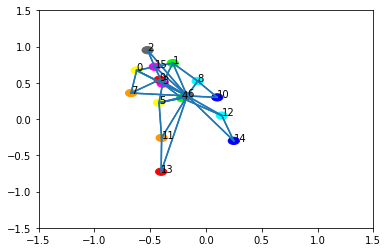

In [40]:
fig = plt.figure()
ax = plt.axes()
activity = athletes[0].get('Right Kick')
ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate_function, 
                                         fargs=(activity, edges, node_html_colors), 
                                         frames=len(activity))
HTML(ani.to_jshtml()) 

In [13]:
ani.save('../animation.gif', writer='imagemagick', fps=5)

# Unindo grafos de uma atividade

In [14]:
frames = athletes[0].get('Back Kick')
print(len(frames))
print(frames.shape)

44
(44, 16, 3)


In [15]:
def unfold_features(data):
    num_frames = data.shape[0]
    num_nodes = data.shape[1]
    num_dim = data.shape[2]
    res = np.zeros((num_frames, num_nodes, num_nodes*num_dim))
    for frame_idx in range(num_frames):
        for node_idx in range(num_nodes):
            res[frame_idx, node_idx, num_dim*node_idx:num_dim*(node_idx+1)] = data[frame_idx,node_idx]
    return res

temp = unfold_features(frames)


In [16]:
st_data, st_edges = ops.create_st_graph(unfold_features(frames), edges, 20)


print(st_data.shape)
print(st_edges.shape)

(704, 48)
(2, 4536)


In [17]:
st_data_vis, st_edges_vis = ops.create_st_graph(frames[5:15], edges, 16)
agrb = vis.ActivityGraphRendererBuilder(16, frame_spacing=1, node_scale=.05, node_colors=node_html_colors)
agrb.add_data(st_data_vis[:,0:2], st_edges_vis)
display(agrb.build_renderer())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

# Unindo atividades para criar uma sequência

## Aqui estou desmembrando as features

In [18]:
def indices_to_one_hot(data, num_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = data.reshape(-1).astype(int)
    return np.eye(num_classes)[targets]

def create_activity_sequence(athlete):

    sequence_frames = []
    sequence_labels = []

    # Build graph
    for label in labels:
        frames = athlete.get(label)
        sequence_frames.append(frames)

    sequence_frames = np.concatenate( sequence_frames )
    sequence_st_data, sequence_st_edges = ops.create_st_graph(unfold_features(sequence_frames), edges, 16)



    # Build labels
    for label in labels:
        frames = athlete.get(label)
        total_nodes = frames.shape[0]*frames.shape[1]
        sequence_labels.append(np.ones(total_nodes) * label_idx[label])

    sequence_labels = np.concatenate( sequence_labels )
    # sequence_labels = indices_to_one_hot(sequence_labels, 7)
    
    return sequence_st_data, sequence_st_edges, sequence_labels

sequence_st_data, sequence_st_edges, sequence_labels = create_activity_sequence(train_athletes[1])
print(sequence_st_data.shape)
print(sequence_st_edges.shape)
print(sequence_labels.shape)

(3392, 48)
(2, 20320)
(3392,)


# Criando dados de entrada para a rede

In [19]:

train_list = []
for i in range(len(train_athletes)):
    sequence_st_data, sequence_st_edges, sequence_labels = create_activity_sequence(train_athletes[i])
    data = Data(
            x=torch.tensor(sequence_st_data, dtype=torch.float), 
            edge_index=torch.tensor(sequence_st_edges, dtype=torch.long), 
            y=torch.tensor(sequence_labels, dtype=torch.long)
            )
    train_list.append(data)
    
validation_list = []
for i in range(len(validation_athletes)):
    sequence_st_data, sequence_st_edges, sequence_labels = create_activity_sequence(validation_athletes[i])
    data = Data(
            x=torch.tensor(sequence_st_data, dtype=torch.float), 
            edge_index=torch.tensor(sequence_st_edges, dtype=torch.long), 
            y=torch.tensor(sequence_labels, dtype=torch.long)
            )
    validation_list.append(data)
    
train_batch = Batch.from_data_list(train_list)
validation_batch = Batch.from_data_list(validation_list)
print('Train set')
print(train_batch)
print('Validation set')
print(validation_batch)

Train set
Batch(batch=[302736], edge_index=[2, 1814176], x=[302736, 48], y=[302736])
Validation set
Batch(batch=[9456], edge_index=[2, 56672], x=[9456, 48], y=[9456])


# Criando a GCN

In [47]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv, GATConv, SignedConv,SGConv
from torch_scatter import scatter_mean

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = GATConv(48, 24)
        #self.conv2 = GATConv(24, 8)
        #self.conv3 = GATConv(8, 7)
        self.conv1 = SGConv(48, 8)
        self.conv2 = SGConv(8, 8)
        self.conv3 = SGConv(8, 7)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv4(x, edge_index)
        # x = F.relu(x)
        return F.softmax(x)

[9999/10000] Loss: 1.6481 / Acc_val: 0.3358 / Acc_train: 0.5124


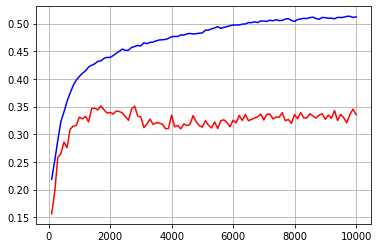

In [48]:
from IPython.display import clear_output, display

device = torch.device('cuda')
model = Net().to(device)
train_data = train_batch.to(device)
validation_data = validation_batch.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
epochs = 10000
model.train()
acc_history_val = []
acc_history_train = []
epoch_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(train_data)
    # print(out.shape)
    # print(out[0])
    # loss = F.nll_loss(out, data.y)
    loss = F.cross_entropy(out, train_data.y)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()
    if (epoch + 1) % 100 == 0:
        _, pred = model(validation_data).max(dim=1)
        correct = float (pred.eq(validation_data.y).sum().item())
        acc_val = correct / float(validation_data.y.shape[0])
        
        _, pred = model(train_data).max(dim=1)
        correct = float (pred.eq(train_data.y).sum().item())
        acc_train = correct / float(train_data.y.shape[0])
        
        acc_history_val.append(acc_val)
        acc_history_train.append(acc_train)
        epoch_history.append(epoch)
        clear_output(wait=True)
        
        print('[{}/{}] Loss: {:.4f} / Acc_val: {:.4f} / Acc_train: {:.4f}'.format(epoch, epochs, total_loss, acc_val, acc_train))
        fig, ax = plt.subplots()
        ax.plot(epoch_history, acc_history_val, 'r')
        ax.plot(epoch_history, acc_history_train, 'b')
        ax.grid()       
        plt.show()
    

In [22]:
torch.save(model, '../model/taekwondo_activity_segmentation_exp5.pth')

/home/danilo/anaconda3/envs/pygeo/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
conv1.weight 	 torch.Size([48, 8])
conv1.att 	 torch.Size([1, 1, 16])
conv1.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([8, 8])
conv2.att 	 torch.Size([1, 1, 16])
conv2.bias 	 torch.Size([8])
conv3.weight 	 torch.Size([8, 7])
conv3.att 	 torch.Size([1, 1, 14])
conv3.bias 	 torch.Size([7])


# Testando um caso

In [29]:
test_athlete = 0
test_data = validation_data.to_data_list()[test_athlete]
_, pred = model(test_data).max(dim=1)
pred_cpu = pred.cpu().numpy()
label_cpu = test_data.y.cpu().numpy()
result = pred_cpu==label_cpu
print('Accuracy: {}'.format(result.sum()/pred_cpu.shape[0]))

Accuracy: 0.5193452380952381


/home/danilo/anaconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
label_colors = {
    0: matplotlib.colors.to_rgb('#c62bc6'),
    1: matplotlib.colors.to_rgb('#49bcad'),
    2: matplotlib.colors.to_rgb('#e1ff00'),
    3: matplotlib.colors.to_rgb('#00bbff'),
    4: matplotlib.colors.to_rgb('#ffd800'),
    5: matplotlib.colors.to_rgb('#00ff11'),
    6: matplotlib.colors.to_rgb('#001dff'),
    7: matplotlib.colors.to_rgb('#fff600'),
    8: matplotlib.colors.to_rgb('#d65968'),
}

{'Left Kick To The Head', 'Right Kick To The Head', 'Right Kick', 'Back Kick', 'Right Punch', 'Left Punch', 'Left Kick'}


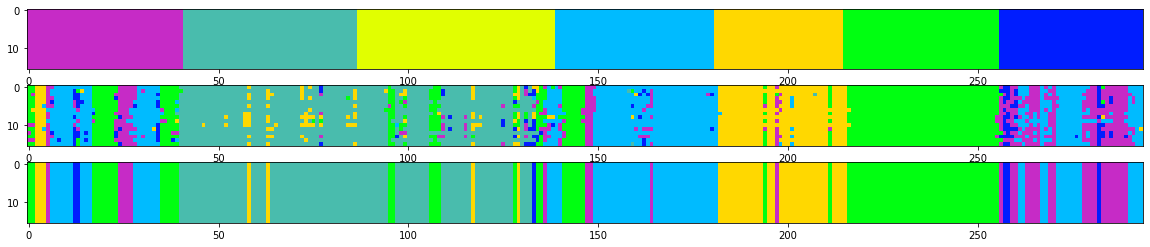

In [31]:
from scipy import stats

ground_truth = label_cpu.flatten()
colored_labels = np.array([ label_colors[i] for i in label_cpu.flatten()])
colored_labels = colored_labels.reshape((-1,16, 3))

colored_preds = np.array([ label_colors[i] for i in pred_cpu.flatten()])
colored_preds = colored_preds.reshape((-1,16, 3))

frame_wise_mode = stats.mode(pred_cpu.reshape((-1,16)), axis=1)
frame_pred = frame_wise_mode[0]
colored_frame_pred = np.array([ [label_colors[i] for j in range(16)]  for i in frame_pred.flatten()])

print(labels)
fig=plt.figure(figsize=(20, 4))
fig.add_subplot(3, 1, 1)
plt.imshow(np.transpose(colored_labels, (1,0,2)))
fig.add_subplot(3, 1, 2)
plt.imshow(np.transpose(colored_preds, (1,0,2)))
fig.add_subplot(3, 1, 3)
plt.imshow(np.transpose(colored_frame_pred, (1,0,2)))

plt.show()

In [32]:
ground_truth = label_cpu.reshape((-1,16))[:,0]
final_pred = frame_pred.flatten()
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
cm = confusion_matrix(ground_truth, final_pred) 

[[ 5  1  0 16  3 14  2]
 [ 0 44  0  0  2  0  0]
 [ 1 38  0  2  2  8  1]
 [ 3  0  0 33  0  6  0]
 [ 1  0  0  1 30  2  0]
 [ 0  0  0  0  1 40  0]
 [20  0  0 15  0  0  3]]


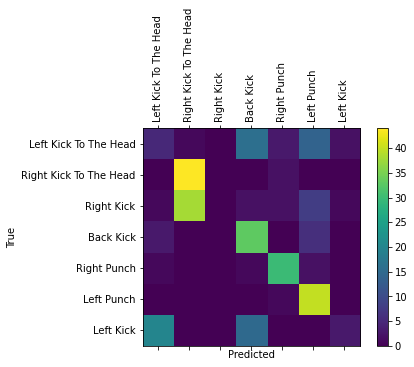

In [33]:
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
# plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xticks(rotation='vertical')
ax.set_xticklabels([''] + list(labels))
ax.set_yticklabels([''] + list(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
cm

array([[39,  0,  0,  0, 11,  0,  3],
       [20,  0,  0,  0, 29,  0,  0],
       [ 0,  0,  0,  0, 17, 24,  0],
       [18,  0,  0,  0,  1,  1, 30],
       [ 9,  0,  0,  0, 14, 10,  0],
       [ 0,  0,  4,  0, 14, 26,  0],
       [ 8,  0,  0,  0,  0,  1, 21]])